The code consists of the following parts:

1. **Section 1** - Prepare datasets
2. **Section 2** - Modelling
3. **Section 3** - Fine-tuning
4. **Section 4** - Evaluation

In [1]:
# Load Libraries & Dataset
import os
import numpy as np
import pandas as pd
import xgboost as xgb
from utils import merge_data
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, roc_curve, auc

data_path = '/Volumes/WORK/dataset/retail_project/cleaned_data/cleaned_data.csv'
products_data_path = '/Volumes/WORK/dataset/retail_project/cleaned_data/potential_products.csv'

In [2]:
potential_products_df = pd.read_csv(products_data_path)
data = pd.read_csv(data_path)
data['invoice_date'] = pd.to_datetime(data['invoice_date'])
data['potential_products'] = np.where(data['stock_code'].isin(potential_products_df['stock_code'].unique()),1,0)

In [3]:
df_2010 = data[data['invoice_date'].dt.year == 2010].reset_index(drop=True)

In [4]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:  # 9, 10, 11
        return 'autumn'


In [5]:
# df_2010['season'] = df_2010['month'].apply(get_season)

In [6]:
# df_2010['num_invoice_winter'] = (df_2010[df_2010['season'] == 'winter'].groupby('customer_id')['invoice'].transform('nunique'))
# df_2010['num_invoice_winter'] = df_2010['num_invoice_winter'].fillna(0) 

# df_2010['num_invoice_spring'] = (df_2010[df_2010['season'] == 'spring'].groupby('customer_id')['invoice'].transform('nunique'))
# df_2010['num_invoice_spring'] = df_2010['num_invoice_spring'].fillna(0) 

# df_2010['num_invoice_summer'] = (df_2010[df_2010['season'] == 'summer'].groupby('customer_id')['invoice'].transform('nunique'))
# df_2010['num_invoice_summer'] = df_2010['num_invoice_summer'].fillna(0) 

# df_2010['num_invoice_autumn'] = (df_2010[df_2010['season'] == 'autumn'].groupby('customer_id')['invoice'].transform('nunique'))
# df_2010['num_invoice_autumn'] = df_2010['num_invoice_autumn'].fillna(0) 

In [8]:
# df_2010 = df_2010[['customer_id','num_invoice_winter','num_invoice_spring','num_invoice_summer','num_invoice_autumn']].drop_duplicates()

In [9]:
# data = merge_data(data, df_2010, 'customer_id', 'customer_id', None, 'left')

## Section 1: Prepare datasets

In [30]:
def grouped_data(df, group_col, value_col, group_type):
    grouped_df = df.groupby(group_col).agg({value_col: group_type}).reset_index()
    return grouped_df

def categorize(row, ox, oy):
    if row[ox] == 5 and 4 <= row[oy] <= 5:
        return 'Champions'
    elif 3 <= row[ox] <= 4 and 4 <= row[oy] <= 5:
        return 'Loyal Customer'
    elif 4 <= row[ox] <= 5 and 2 <= row[oy] <= 3:
        return 'Potential Loyalist'
    elif row[ox] == 5 and row[oy] == 1:
        return 'New Customers'
    elif row[ox] == 4 and row[oy] == 1:
        return 'Promising'
    elif row[ox] == 3 and 1 <= row[oy] <= 2:
        return 'Needs Attention'
    elif row[ox] == 3 and row[oy] == 3:
        return 'About to Sleep'
    elif 1 <= row[ox] <= 2 and row[oy] == 5:
        return 'Can\'t Loose Them'
    elif 1 <= row[ox] <= 2 and 3 <= row[oy] <= 4:
        return 'At Risk'
    elif 1 <= row[ox] <= 2 and 1 <= row[oy] <= 2:
        return 'Hibernating'
    else:
        return 'Unclassified'


def segment_customers_rfm(df):
    # df['invoice_date'] = pd.to_datetime(df['invoice_date'])
    reference_date = df['invoice_date'].max() + pd.Timedelta(days=1)

    # Calculate R,F,M
    rfm = df.groupby('customer_id').agg({
        'invoice_date': lambda x: (reference_date - x.max()).days,  # Recency
        'invoice': 'nunique',                                       # Frequency
        'revenue': 'sum'                                            # Monetary
    }).reset_index()
    
    rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']
    rfm['recency_score'] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1])
    rfm['monetary_score'] = pd.qcut(rfm['monetary'], 5, labels=[1,2,3,4,5])

    rfm['segment_customers'] = rfm.apply(categorize, axis=1, args=('recency_score', 'monetary_score'))
    return rfm
    


def created_feature_engineering(data):
    df = data.copy()
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])
    ####### Feature engineering
    df_feat_eng = df[['customer_id','label']].drop_duplicates()
    
    ####  1. Number of Invoices per Customer (num_invoices)
    # # Compute groupby aggregations
    # invoices_df = grouped_data(df[df['invoice_type']=='purchase'], 'customer_id', 'invoice', 'nunique')
    # invoices_df = invoices_df.rename(columns={'invoice': 'num_invoice'})
    # # Merge with feature engineering data
    # df_feat_eng = merge_data(df_feat_eng, invoices_df[['customer_id','num_invoice']], 'customer_id', 'customer_id', None, 'left')
    
    ####  2. Average Revenue per Invoice per Customer (avg_invoice_revenue)
    # Compute groupby aggregations
    revenue_per_invoice = grouped_data(df, ['customer_id', 'invoice'], 'revenue', 'sum')
    avg_invoice_revenue =  revenue_per_invoice.groupby('customer_id').agg(avg_invoice_revenue = ('revenue', 'mean')).reset_index()
    # Merge with feature engineering data
    df_feat_eng = merge_data(df_feat_eng, avg_invoice_revenue[['customer_id','avg_invoice_revenue']], 'customer_id', 'customer_id', None, 'left')
    
    ####  3. Average Purchase Interval per Customer (avg_purchase_interval)
    # Compute groupby aggregations
    invoice_dates = df[df['invoice_type']=='purchase'][['customer_id', 'invoice_date']].drop_duplicates(keep='first')
    invoice_dates['invoice_date'] = pd.to_datetime(invoice_dates['invoice_date'])
    invoice_dates = invoice_dates.sort_values(by=['customer_id', 'invoice_date'])
    invoice_dates['purchase_interval'] = invoice_dates.groupby('customer_id')['invoice_date'].diff().dt.days
    avg_purchase_interval = grouped_data(invoice_dates, 'customer_id', 'purchase_interval', 'mean')
    avg_purchase_interval = avg_purchase_interval.rename(columns={'purchase_interval': 'avg_purchase_interval'})
    # Merge with feature engineering data
    df_feat_eng = merge_data(df_feat_eng, avg_purchase_interval[['customer_id','avg_purchase_interval']], 'customer_id', 'customer_id', None, 'left')
    df_feat_eng['avg_purchase_interval'] = df_feat_eng['avg_purchase_interval'].fillna(1000)
    
    ####  4. Average Product Price per Customer (avg_price)
    # Compute groupby aggregations
    stock_code_price_per_customer = df[df['invoice_type']=='purchase'][['customer_id', 'invoice_date','price']].sort_values('invoice_date', ascending=False)
    stock_code_price_per_customer = stock_code_price_per_customer.drop_duplicates(subset='customer_id', keep='first').reset_index(drop=True)
    avg_price = grouped_data(stock_code_price_per_customer, 'customer_id', 'price', 'mean')
    avg_price = avg_price.rename(columns={'price': 'avg_price'})
    # Merge with feature engineering data
    df_feat_eng = merge_data(df_feat_eng, avg_price[['customer_id','avg_price']], 'customer_id', 'customer_id', None, 'left')
    
    ####  5. Number of Product Types per Customer (num_product_types)
    # Compute groupby aggregations
    num_product_types = grouped_data(df[df['invoice_type']=='purchase'], 'customer_id', 'stock_code', 'nunique')
    num_product_types = num_product_types.rename(columns={'stock_code': 'num_product_types'})
    # Merge with feature engineering data
    df_feat_eng = merge_data(df_feat_eng, num_product_types[['customer_id','num_product_types']], 'customer_id', 'customer_id', None, 'left')
        
    ####  6. Revenue per Customer (revenue)
    # Compute groupby aggregations
    revenue = grouped_data(df, 'customer_id', 'revenue', 'sum')
    # Merge with feature engineering data
    df_feat_eng = merge_data(df_feat_eng, revenue[['customer_id','revenue']], 'customer_id', 'customer_id', None, 'left')

    #### 7. Top10 products purchase count (top10_products_purchase_count)
    # Compute groupby aggregations
    top10_products_purchase_count = grouped_data(df[df['potential_products']==1], 'customer_id', 'quantity', 'sum')
    top10_products_purchase_count = top10_products_purchase_count.rename(columns={'quantity': 'top10_products_purchase_count'})
    # Merge with feature engineering data
    df_feat_eng = merge_data(df_feat_eng, top10_products_purchase_count[['customer_id','top10_products_purchase_count']], 'customer_id', 'customer_id', None, 'left')
    df_feat_eng['top10_products_purchase_count'] = df_feat_eng['top10_products_purchase_count'].fillna(0)

    #### 8. Recency top10 purchase days (recency_top10_purchase_days)
    last_top10_purchase_date = df[df['potential_products']==1].groupby('customer_id').agg(last_top10_purchase_date = ('invoice_date', 'max')).reset_index()
    reference_date = df['invoice_date'].max() + pd.Timedelta(days=1)
    last_top10_purchase_date['recency_top10_purchase_days'] = (
        reference_date - last_top10_purchase_date['last_top10_purchase_date']
    ).dt.days
    # Merge with feature engineering data
    df_feat_eng = merge_data(df_feat_eng, last_top10_purchase_date[['customer_id','recency_top10_purchase_days']], 'customer_id', 'customer_id', None, 'left')
    df_feat_eng['recency_top10_purchase_days'] = df_feat_eng['recency_top10_purchase_days'].fillna(1000)


    #### 9. Revenue top10
    # revenue_top10 = df[df['invoice_type']=='return'].groupby('customer_id').agg(revenue_top10 = ('revenue', 'sum')).reset_index()
    # Merge with feature engineering data
    
    # df_2010 = df[['customer_id','num_invoice_autumn']].drop_duplicates()
    
    # df_feat_eng = merge_data(df_feat_eng, df_2010, 'customer_id', 'customer_id', None, 'left')
    # df_feat_eng['num_invoice_autumn'] = df_feat_eng['num_invoice_autumn'].fillna(0)



    #### 10. Revenue trend (revenue_trend)
    df_sorted = data.sort_values(by=['customer_id', 'invoice_date'])
    first_revenue = data.groupby('customer_id').first()['revenue']
    last_revenue = data.groupby('customer_id').last()['revenue']
    revenue_trend = last_revenue - first_revenue
    trend_df = revenue_trend.reset_index().rename(columns={'revenue': 'revenue_trend'})
    # Merge with feature engineering data
    df_feat_eng = merge_data(df_feat_eng, trend_df[['customer_id','revenue_trend']], 'customer_id', 'customer_id', None, 'left')
 

    return df_feat_eng


def created_dataset(min_time, max_time, data):
    #### Get months
    months = data[(data['month']<=max_time)&(data['month']>=min_time)]['month'].unique()

    #### Split dataset
    # Feature data
    feature_df =  data[data['month'].isin(sorted(months, reverse=False)[:5])].copy()
    feature_customers = feature_df['customer_id'].unique()
    
    # Labled data
    labeled_data = data[
        (data['month'].isin(sorted(months, reverse=False)[5:7])) &
        (data['potential_products']==1) &
        (data['customer_id'].isin(feature_customers))
    ]
    
    # Assign label 
    return_customers =  labeled_data[labeled_data['invoice_type']=='purchase']['customer_id'].unique()  
    feature_df['label'] = np.where(feature_df['customer_id'].isin(return_customers),1,0)

    #### Created feature engineering
    x_data =  created_feature_engineering(feature_df)

    

    #### Segment customers rfm
    segment_customers = segment_customers_rfm(feature_df)
    x_data = merge_data(x_data, segment_customers[['customer_id','recency','segment_customers']], 'customer_id', 'customer_id', None, 'left')

    return x_data

In [32]:
test_dataset = created_dataset('2011-05', '2011-11', data)
validation_dataset = created_dataset('2011-03', '2011-09', data)
train_dataset = created_dataset('2011-01', '2011-07', data)

In [35]:
scaler = StandardScaler()
cols_to_scale = ['avg_invoice_revenue',
   'avg_purchase_interval', 'avg_price', 'num_product_types', 'revenue',
   'top10_products_purchase_count', 'recency_top10_purchase_days', 'revenue_trend','recency']
train_dataset[cols_to_scale] = scaler.fit_transform(train_dataset[cols_to_scale])

validation_dataset[cols_to_scale] = scaler.transform(validation_dataset[cols_to_scale])
test_dataset[cols_to_scale] = scaler.transform(test_dataset[cols_to_scale])

In [37]:
test_dataset

,customer_id,label,avg_invoice_revenue,avg_purchase_interval,avg_price,num_product_types,revenue,top10_products_purchase_count,recency_top10_purchase_days,revenue_trend,recency,segment_customers
0,15606,0,-0.058998,-1.010606,-0.164750,-0.405965,-0.027563,-0.195189,1.195287,0.266875,-0.044218,Loyal Customer
1,14800,0,-0.341986,-1.055955,-0.242346,1.752620,0.132867,-0.195189,1.195287,0.061186,-1.134836,Champions
2,16931,1,-0.292846,-1.079513,-0.240555,3.870088,0.248995,0.040586,-0.813629,0.061186,-1.134836,Champions
3,15708,1,-0.161939,-0.941960,0.241733,0.416353,0.010155,0.033441,-0.798637,0.014874,0.426731,At Risk
4,14304,0,0.100093,0.963504,-0.071635,-0.447081,-0.194235,-0.195189,1.195287,-0.100519,2.508820,At Risk
...,...,...,...,...,...,...,...,...,...,...,...,...
2761,15034,1,-0.068950,0.963504,-0.167137,1.176997,-0.124555,-0.166610,-0.944272,0.108620,-1.258770,Potential Loyalist
2762,15185,0,-0.060505,0.963504,-0.242346,-0.364849,-0.216286,-0.195189,1.195287,-0.018761,-1.258770,Potential Loyalist
2763,16404,0,0.231516,0.963504,0.029837,-0.323733,-0.176189,-0.138031,-0.944272,0.036607,-1.258770,Potential Loyalist
2764,12842,0,1.036840,0.963504,-0.093123,-0.385407,-0.065608,0.262070,-0.944272,0.510080,-1.258770,Champions


## Section 2: Modelling

In [40]:
def prepare_dmatrix(df, label_col):
    X = df.drop(columns=[label_col, 'segment_customers'])
    y = df[label_col]
    return xgb.DMatrix(X, label=y)

def train_model(params, dtrain, dvalid, num_boost_round, early_stopping_rounds=10):
    evals = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=evals,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=False
    )
    return model

def predict(model, dmatrix, threshold=0.5):
    y_pred_prob = model.predict(dmatrix)
    y_pred = (y_pred_prob >= threshold).astype(int)
    return y_pred_prob, y_pred

def evaluate(y_true, y_pred, y_pred_prob):
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_prob)
    recall   = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)  
    return accuracy, auc, recall, precision, f1

def feature_importance(model, importance_type='weight', top_n=10):
    importance = model.get_score(importance_type=importance_type)
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    return sorted_importance

In [44]:
params = {
    'objective': 'binary:logistic',  # bài toán phân loại nhị phân, output là xác suất
    'eval_metric': 'error',             # metric đánh giá là AUC
    'eta': 0.1,                      # learning rate (còn gọi là learning step size)
    'max_depth': 6,                  # độ sâu tối đa của cây
    'min_child_weight': 1,           # số mẫu tối thiểu để phân tách node
    'subsample': 0.8,                # tỷ lệ lấy mẫu ngẫu nhiên cho mỗi cây
    'colsample_bytree': 0.8,         # tỷ lệ lấy mẫu feature mỗi cây
    # 'scale_pos_weight': 1.8,
    'seed': 42,                     # để đảm bảo kết quả reproducible
    'verbosity': 0                   # 0 im lặng, 1 in thông tin
}

label_col = 'label'

# Prepare DMatrix
dtrain = prepare_dmatrix(train_dataset, label_col)
dvalid = prepare_dmatrix(validation_dataset, label_col)

# Train model
model = train_model(params, dtrain, dvalid, num_boost_round=100, early_stopping_rounds=5)

# Predict test
y_val_true = validation_dataset[label_col]
y_pred_prob, y_pred = predict(model, dvalid, threshold=0.5)

# Evaluation
accuracy, score_auc, recall, precision, f1 = evaluate(y_val_true, y_pred, y_pred_prob)

print(f"Validation Precision: {precision:.4f}")

Validation Precision: 0.6821


In [46]:
print(model.attributes())         

{'best_iteration': '15', 'best_score': '0.1983975581838993'}


In [48]:
dtest = prepare_dmatrix(test_dataset, label_col)

# Train model
model = train_model(params, dtrain, dvalid, num_boost_round=100, early_stopping_rounds=5)

# Predict test
y_val_true = test_dataset[label_col]
y_pred_prob, y_pred = predict(model, dtest, threshold=0.5)

# Evaluation
accuracy, score_auc, recall, precision, f1 = evaluate(y_val_true, y_pred, y_pred_prob)

print(f"Validation Precision: {precision:.4f}")

Validation Precision: 0.6731


## Section 3: Fine-tuning

In [51]:
results = []

tree_counts = [10,20,30,40]
max_depths = list(range(3, 11))

for nt in tree_counts:
    for md in max_depths:
        params_loop = params.copy()
        params_loop['max_depth'] = md
        dtrain = prepare_dmatrix(train_dataset, 'label')
        dvalid = prepare_dmatrix(validation_dataset, 'label')
        model_loop = train_model(params_loop, dtrain, dvalid, num_boost_round=nt, early_stopping_rounds=5)
        y_prob, y_pred = predict(model_loop, dvalid)
        accuracy, auc, recall, precision, f1  = evaluate(validation_dataset['label'], y_pred, y_prob)
        results.append({'num_trees': nt, 'max_depth': md, 'accuracy': accuracy, 'auc': auc, 
                        'recall': recall, 'precision': precision, 'f1':f1})

df_results = pd.DataFrame(results)

In [52]:
df_results

,num_trees,max_depth,accuracy,auc,recall,precision,f1
0,10,3,0.792064,0.789453,0.207874,0.758621,0.326329
1,10,4,0.793972,0.786815,0.218898,0.759563,0.339853
2,10,5,0.795879,0.783236,0.222047,0.774725,0.345165
3,10,6,0.795879,0.777888,0.226772,0.765957,0.349939
4,10,7,0.793209,0.776433,0.223622,0.743455,0.343826
5,10,8,0.798932,0.771618,0.242520,0.770000,0.368862
6,10,9,0.797024,0.776665,0.248819,0.741784,0.372642
7,10,10,0.794735,0.766856,0.237795,0.736585,0.359524
8,20,3,0.803129,0.790550,0.316535,0.710247,0.437908
9,20,4,0.804273,0.788709,0.322835,0.711806,0.444204


In [55]:
df_results['precision'].max()

np.float64(0.7747252747252747)

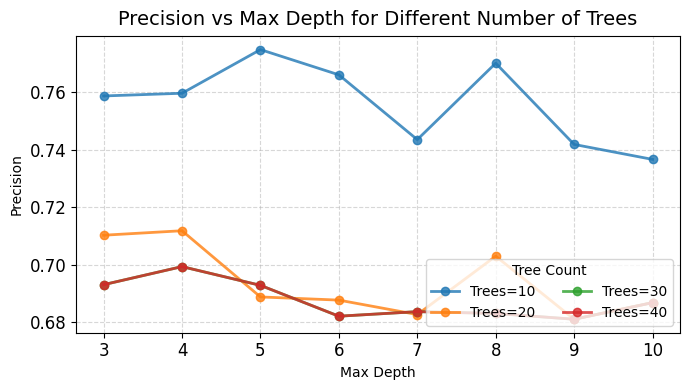

In [57]:
plt.figure(figsize=(7, 4))                    # Kích thước figure
for i, nt in enumerate(tree_counts):
    subset = df_results[df_results['num_trees'] == nt]
    plt.plot(
        subset['max_depth'],
        subset['precision'],
        label=f'Trees={nt}',
        linewidth=2,                            # Độ dày đường
        marker='o',                             # Marker tròn
        markersize=6,                           # Kích thước marker
        linestyle='-',                          # Kiểu đường liền
        alpha=0.8                               # Độ trong suốt
    )

plt.grid(True, linestyle='--', alpha=0.5)        # Hiện grid
plt.xlabel('Max Depth', fontsize=10)            # Font lớn hơn
plt.ylabel('Precision', fontsize=10)
plt.title('Precision vs Max Depth for Different Number of Trees', fontsize=14, pad=8)
plt.xticks(range(3, 11), fontsize=12)            # Chỉ số trên trục x
plt.yticks(fontsize=12)
# plt.ylim(0.72, 0.85)
plt.legend(title='Tree Count', fontsize=10, title_fontsize=10, loc='lower right', ncol=2)
plt.tight_layout()
plt.show()

In [44]:
results = []
lr_list = list(np.arange(0.1, 1.1, 0.1))
for lr in lr_list:
    params_loop = params.copy()
    params_loop['max_depth'] = 4
    params_loop['eta'] = lr
    dtrain = prepare_dmatrix(train_dataset, 'label')
    dvalid = prepare_dmatrix(validation_dataset, 'label')
    model_loop = train_model(params_loop, dtrain, dvalid, num_boost_round=10, early_stopping_rounds=5)
    y_prob, y_pred = predict(model_loop, dvalid)
    accuracy, auc, recall, precision, f1  = evaluate(validation_dataset['label'], y_pred, y_prob)
    results.append({'lr': lr, 'accuracy': accuracy, 'auc': auc, 
                    'recall': recall, 'precision': precision, 'f1':f1})

df_results = pd.DataFrame(results)

In [45]:
df_results

,lr,accuracy,auc,recall,precision,f1
0,0.1,0.797406,0.796281,0.229921,0.776596,0.354800
1,0.2,0.804655,0.792680,0.327559,0.709898,0.448276
2,0.3,0.803129,0.796503,0.368504,0.670487,0.475610
3,0.4,0.799695,0.793471,0.384252,0.645503,0.481737
4,0.5,0.797787,0.790163,0.395276,0.632242,0.486434
5,0.6,0.795116,0.778945,0.395276,0.621287,0.483157
6,0.7,0.789775,0.773874,0.395276,0.600478,0.476733
7,0.8,0.781763,0.779928,0.414173,0.568035,0.479053
8,0.9,0.790919,0.767180,0.437795,0.592751,0.503623
9,1.0,0.787486,0.757190,0.420472,0.585526,0.489459


In [50]:
def train_model(params, dtrain):
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=16,
        verbose_eval=False
    )
    return model

In [54]:
test_dataset = created_dataset('2011-05', '2011-11', data)
validation_dataset = created_dataset('2011-03', '2011-09', data)
train_dataset = created_dataset('2011-01', '2011-07', data)

In [56]:
scaler = StandardScaler()
cols_to_scale = ['avg_invoice_revenue',
   'avg_purchase_interval', 'avg_price', 'num_product_types', 'revenue',
   'top10_products_purchase_count', 'recency_top10_purchase_days',
   'num_invoice_autumn', 'revenue_trend']
validation_dataset[cols_to_scale] = scaler.fit_transform(validation_dataset[cols_to_scale])

test_dataset[cols_to_scale] = scaler.transform(test_dataset[cols_to_scale])

In [58]:
# params_loop['eta'] = 0.1
dtest = prepare_dmatrix(test_dataset, 'label')
model_loop = train_model(params, dvalid)
y_prob, y_pred = predict(model_loop, dtest)

## Section 4: Evaluation

### 4.1: Features important

In [62]:
test_dataset.isnull().sum()

customer_id                       0
label                             0
avg_invoice_revenue               0
avg_purchase_interval             0
avg_price                        29
num_product_types                29
revenue                           0
top10_products_purchase_count     0
recency_top10_purchase_days       0
num_invoice_autumn                0
revenue_trend                     0
recency                           0
segment_customers                 0
dtype: int64

In [64]:
sorted_importance= feature_importance(model, importance_type='weight', top_n=10)

print("\nFeature importances:")
for feature, score in sorted_importance[:20]:
    print(f"{feature}: {score}")



Feature importances:
customer_id: 103.0
revenue: 94.0
num_invoice_autumn: 91.0
recency: 89.0
num_product_types: 88.0
avg_price: 87.0
top10_products_purchase_count: 75.0
avg_invoice_revenue: 71.0
revenue_trend: 68.0
avg_purchase_interval: 65.0
recency_top10_purchase_days: 59.0


### 4.2: Segment customers rfm 

In [67]:
dtest  = prepare_dmatrix(test_dataset, 'label')
y_test_true = test_dataset['label']
y_pred_prob, y_pred = predict(model, dtest, threshold=0.5)
test_dataset['pred_prob'] = y_pred_prob

# Evaluation
accuracy, auc, recall, precision, f1 = evaluate(y_test_true, y_pred, y_pred_prob)

In [69]:
rfm_top_customers =  test_dataset[test_dataset['segment_customers'].isin(["Champions","Loyal Customer","Can\'t Loose Them"])]

In [71]:
rfm_top_customers['customer_id'].nunique()

950

In [73]:
rfm_top_customers[rfm_top_customers['label']==1]['customer_id'].nunique()/rfm_top_customers['customer_id'].nunique()

0.3989473684210526

In [75]:
# rs = []
# for n in list(np.arange(50, 2600, 50)):
#     prob_top_customers = validation_dataset.sort_values(by='pred_prob',ascending=False).head(n)
#     value = prob_top_customers[prob_top_customers['label']==1]['customer_id'].nunique()/validation_dataset[validation_dataset['label']==1]['customer_id'].nunique()
#     rs.append(value)

In [77]:
# df = pd.DataFrame({'values': rs}, index=list(np.arange(50, 2600, 50)))

In [79]:
prob_top_customers = test_dataset.sort_values(by='pred_prob',ascending=False).head(rfm_top_customers['customer_id'].nunique())

In [81]:
prob_top_customers[prob_top_customers['label']==1]['customer_id'].nunique()/prob_top_customers['customer_id'].nunique()

0.4536842105263158

In [83]:
prob_top_customers['customer_id'].nunique()

950

In [85]:
validation_dataset[validation_dataset['label']==1]['customer_id'].nunique()

635

In [105]:
def random_top(num, num_iteration, data):
    results = []
    for i in range(0,num_iteration):
        random_df = data.sample(n=num, replace=False)
    
        value = random_df[random_df['label']==1]['customer_id'].nunique()/random_df['customer_id'].nunique()
        results.append(value)

    return sum(results) / len(results)

In [111]:
random_top(950, 100,test_dataset)

0.2574526315789474

In [86]:
349/635

0.5496062992125984